In [241]:
import textstat
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from scipy.stats.stats import pearsonr   
from scipy.stats import ttest_rel

from matplotlib import pyplot as plt
plt.style.use('ggplot')

from tqdm.auto import tqdm 
tqdm.pandas(desc='Progress')

import ray
ray.shutdown()
ray.init()

import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

import warnings
warnings.filterwarnings('ignore')

2022-06-14 02:08:30,949	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


In [242]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams["axes.edgecolor"] = "black"

# Ad hoc text analysis of r/redscarepod comments

There has been much discussion as to whether the subreddit as gotten worse, I will try to investigate further. 

### Load data and get basic info

Data cleaning will not be required because the comments are unique comments from scared from the pushshiftAPI. 

In [2]:
df = pd.read_csv('data/combined.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002938 entries, 0 to 3002937
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   date    object
 1   score   int64 
 2   body    object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [4]:
df.head()

,date,score,body
0,2018-04-12 16:26:09+00:00,4,Offer still stands
1,2018-04-12 08:20:29+00:00,1,[deleted]
2,2018-04-12 06:31:11+00:00,3,i'll do it for $5
3,2018-04-12 02:16:51+00:00,-2,[deleted]
4,2018-04-12 01:37:16+00:00,7,What an ep - of course Dasha had a crush on Dz...


### Format the columns into correct data type

In [5]:
# Make body strings
df['body'] = df['body'].astype(str)

In [6]:
# Fix date time formatting
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'].dt.strftime('%d-%m-%Y'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002938 entries, 0 to 3002937
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   score   int64         
 2   body    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 68.7+ MB


In [7]:
#Need to drop rows that have deleted values
df = df[df['body'] != '[deleted]'].reset_index(drop = True)
df.head()

,date,score,body
0,2018-12-04,4,Offer still stands
1,2018-12-04,3,i'll do it for $5
2,2018-12-04,7,What an ep - of course Dasha had a crush on Dz...
3,2018-11-04,6,Who is the artist they compare Petra Collins t...
4,2018-11-04,7,hell yeah dude


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912446 entries, 0 to 2912445
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   score   int64         
 2   body    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 66.7+ MB


Okay so 2.9M rows, thats way too much!

I will keep 1M that will still be too much, but its reasonable for me. 

In [9]:
df = df.sample(n = 1000000)

### Extract length metrics from comments

In [10]:
#Lets start off by extracting the word count and character count from the comment bodies
# This will help with scaling some of the other metrics later.
df['body_word_count'] = df['body'].progress_apply(lambda row:textstat.lexicon_count(row, removepunct=True))
df['body_character_count'] = df['body'].progress_apply(lambda row:textstat.char_count(row, ignore_spaces=True))

df.head()

Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

,date,score,body,body_word_count,body_character_count
1800225,2021-04-11,37,Unless you're getting paid minimum wage or som...,15,90
1003967,2021-10-02,7,https://twitter.com/AdamFriedland/status/11965...,1,253
500698,2020-11-25,1,Maybe this will help: https://slate.com/cultur...,5,130
2102441,2022-04-24,1,"Also, she loves the Countess. Elegance is lear...",10,50
324624,2020-03-07,1,Dasha more attractive than her,5,26


### Extract grammatical error metrics

In [11]:
# Now lets get the grammatical errors per comment
# We will have to scale that by the number of words or characters.
df['body_num_errors'] = df['body'].progress_apply(lambda row: len(tool.check(row)))
df['body_error_freq'] = df['body_num_errors']/df['body_word_count']

df.head()

Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

,date,score,body,body_word_count,body_character_count,body_num_errors,body_error_freq
1800225,2021-04-11,37,Unless you're getting paid minimum wage or som...,15,90,0,0.0
1003967,2021-10-02,7,https://twitter.com/AdamFriedland/status/11965...,1,253,0,0.0
500698,2020-11-25,1,Maybe this will help: https://slate.com/cultur...,5,130,0,0.0
2102441,2022-04-24,1,"Also, she loves the Countess. Elegance is lear...",10,50,0,0.0
324624,2020-03-07,1,Dasha more attractive than her,5,26,0,0.0


The process above took an UNGODLY amount of time. I considered using parallelization but then the calls to the local server would also have to be in the local scope of the function. And the call is 10x as long as processing 1 row. Parrallization could have given be a 10x improvement, so its probably not worth it. Now handling both those issues could have 

In [13]:
# Saving because I don't want to take my chances with this again.
df.to_csv('extracted.csv', index = False)

 ____________________________ 

### Readability Analysis

In [12]:
# Start from here again
df = pd.read_csv('extracted.csv', index_col = 'index')
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'].dt.strftime('%d-%m-%Y'))
df = df.sort_values(by = 'date')
df = df.reset_index(drop = True)

df.head()

,date,score,body,body_word_count,body_character_count,body_num_errors,body_error_freq
0,2018-04-10,4,I don't have a twitter account but I would if ...,12,40,2,0.166667
1,2018-04-10,11,more edgy stuff that anna tends to talk about ...,25,123,7,0.280000
2,2018-04-10,6,has anyone told anna that there's a subreddit ...,9,42,3,0.333333
3,2018-04-11,7,hell yeah dude,3,12,1,0.333333
4,2018-04-11,6,Who is the artist they compare Petra Collins t...,17,83,1,0.058824


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   date                  1000000 non-null  datetime64[ns]
 1   score                 1000000 non-null  int64         
 2   body                  999994 non-null   object        
 3   body_word_count       1000000 non-null  int64         
 4   body_character_count  1000000 non-null  int64         
 5   body_num_errors       1000000 non-null  int64         
 6   body_error_freq       996370 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 53.4+ MB


In [22]:
# Drop nan values
df = df.dropna()
df = df.reset_index(drop=True)

In [23]:
# Get more metrics
df['body_readability_qual'] = df['body'].progress_apply(lambda row: textstat.text_standard(row, float_output=False))
df['body_readability_quant'] = df['body'].progress_apply(lambda row: textstat.text_standard(row, float_output= True))
df['body_readtime'] = df['body'].progress_apply(lambda row: textstat.reading_time(row, ms_per_char=14.69))
df['body_sylcount'] = df['body'].progress_apply(textstat.polysyllabcount)
df['body_foreign_ease'] = df['body'].progress_apply(textstat.mcalpine_eflaw)

df.head()

Progress:   0%|          | 0/996364 [00:00<?, ?it/s]

Progress:   0%|          | 0/996364 [00:00<?, ?it/s]

Progress:   0%|          | 0/996364 [00:00<?, ?it/s]

Progress:   0%|          | 0/996364 [00:00<?, ?it/s]

Progress:   0%|          | 0/996364 [00:00<?, ?it/s]

,date,score,body,body_word_count,body_character_count,body_num_errors,body_error_freq,body_readability_qual,body_readability_quant,body_readtime,body_sylcount,body_foreign_ease
0,2018-04-10,4,I don't have a twitter account but I would if ...,12,40,2,0.166667,4th and 5th grade,5.0,0.59,0,19.0
1,2018-04-10,11,more edgy stuff that anna tends to talk about ...,25,123,7,0.280000,11th and 12th grade,12.0,1.81,3,33.0
2,2018-04-10,6,has anyone told anna that there's a subreddit ...,9,42,3,0.333333,4th and 5th grade,5.0,0.62,1,12.0
3,2018-04-11,7,hell yeah dude,3,12,1,0.333333,-3th and -2th grade,-2.0,0.18,0,3.0
4,2018-04-11,6,Who is the artist they compare Petra Collins t...,17,83,1,0.058824,0th and 1st grade,1.0,1.22,0,11.0


In [29]:
df.to_csv('extracted.csv', index = False)

______________

### Sentiment Analysis

In [6]:
df = pd.read_csv('extracted.csv')
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'].dt.strftime('%d-%m-%Y'))

In [23]:
# vectorize the polarity score function
vpolarity = np.vectorize(analyser.polarity_scores)
sentiment_arr = vpolarity(df['body'].to_numpy())

sentiment_arr

array([{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, ...,
       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
       {'neg': 0.265, 'neu': 0.51, 'pos': 0.224, 'compound': -0.1027},
       {'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'compound': 0.8309}],
      dtype=object)

In [28]:
def dict_retrieve(dictionary,key):
    """
    Returns value from a dictionary
    To be vectorzied
    """
    return dictionary[key]

vdict_retrieve = np.vectorize(dict_retrieve)

df['neg'] = vdict_retrieve(sentiment_arr, 'neg')
df['neu'] = vdict_retrieve(sentiment_arr, 'neu')
df['pos'] = vdict_retrieve(sentiment_arr, 'pos')
df['comp'] = vdict_retrieve(sentiment_arr, 'compound')

In [29]:
df.head()

,date,score,body,body_word_count,body_character_count,body_num_errors,body_error_freq,body_readability_qual,body_readability_quant,body_readtime,body_sylcount,body_foreign_ease,neg,neu,pos,comp
0,2018-10-04,4,I don't have a twitter account but I would if ...,12,40,2,0.166667,4th and 5th grade,5.0,0.59,0,19.0,0.00,1.000,0.000,0.0000
1,2018-10-04,11,more edgy stuff that anna tends to talk about ...,25,123,7,0.280000,11th and 12th grade,12.0,1.81,3,33.0,0.00,1.000,0.000,0.0000
2,2018-10-04,6,has anyone told anna that there's a subreddit ...,9,42,3,0.333333,4th and 5th grade,5.0,0.62,1,12.0,0.00,1.000,0.000,0.0000
3,2018-11-04,7,hell yeah dude,3,12,1,0.333333,-3th and -2th grade,-2.0,0.18,0,3.0,0.59,0.128,0.282,-0.5267
4,2018-11-04,6,Who is the artist they compare Petra Collins t...,17,83,1,0.058824,0th and 1st grade,1.0,1.22,0,11.0,0.00,0.848,0.152,0.4329


In [30]:
# Keep this for later
df_numeric = df.select_dtypes(include=np.number)
df_numeric.head()

,score,body_word_count,body_character_count,body_num_errors,body_error_freq,body_readability_quant,body_readtime,body_sylcount,body_foreign_ease,neg,neu,pos,comp
0,4,12,40,2,0.166667,5.0,0.59,0,19.0,0.00,1.000,0.000,0.0000
1,11,25,123,7,0.280000,12.0,1.81,3,33.0,0.00,1.000,0.000,0.0000
2,6,9,42,3,0.333333,5.0,0.62,1,12.0,0.00,1.000,0.000,0.0000
3,7,3,12,1,0.333333,-2.0,0.18,0,3.0,0.59,0.128,0.282,-0.5267
4,6,17,83,1,0.058824,1.0,1.22,0,11.0,0.00,0.848,0.152,0.4329


### Summary statistics

In [43]:
df_numeric.describe()

,score,body_word_count,body_character_count,body_num_errors,body_error_freq,body_readability_quant,body_readtime,body_sylcount,body_foreign_ease,neg,neu,pos,comp
count,996364.000000,996364.000000,996364.000000,996364.00000,996364.000,996364.000000,996364.000000,996364.000000,996364.000000,996364.000000,996364.000000,996364.000000,996364.000000
mean,5.439105,23.746129,111.872544,1.35308,inf,6.449180,1.643264,2.080980,16.750543,0.095785,0.770216,0.133999,0.071043
std,15.906966,37.941208,185.576091,2.44524,NaN,11.923505,2.726003,4.369267,13.381760,0.151628,0.211904,0.178840,0.471734
min,-125.000000,0.000000,1.000000,0.00000,0.000,-7.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,1.000000,6.000000,27.000000,0.00000,0.000,2.000000,0.400000,0.000000,8.000000,0.000000,0.657000,0.000000,-0.226300
50%,1.000000,13.000000,58.000000,1.00000,0.040,6.000000,0.850000,1.000000,14.000000,0.000000,0.791000,0.079000,0.000000
75%,3.000000,27.000000,124.000000,2.00000,0.125,9.000000,1.820000,2.000000,22.500000,0.148000,1.000000,0.205000,0.440400
max,847.000000,1729.000000,9390.000000,367.00000,inf,6859.000000,137.940000,295.000000,1376.000000,1.000000,1.000000,1.000000,1.000000


### Look for interesting correlations

<AxesSubplot:>

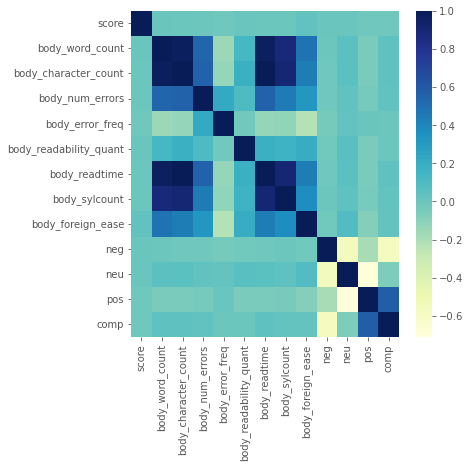

In [36]:
# Heat map
# Good for visaully inspecting correlations
sns.heatmap(df_numeric.corr(), cmap = 'YlGnBu')

In [72]:
pearsonr(df['body_word_count'],df['body_foreign_ease'])

(0.47960750141877073, 0.0)

Nothing of much note here. 

### Check reading grade level

It seems that th readability metric used has grades higher than 15. 
I need to use a better metric. I will use the Dalle-Challe Metric.

In [106]:
def grade_level_bins(score):
    
    if score <= 4.9:
        return '4th Grade'
    elif 4.9 < score <= 5.9:
        return '5th-6th Grade'
    elif 5.9 < score <= 6.9:
        return '7th-8th Grade'
    elif 6.9 < score <= 7.9:
        return '9th-10th Grade'
    elif 7.9 < score <= 8.9:
        return '11th-12th Grade'
    else:
        return 'College level'
        

vdalle_challe = np.vectorize(textstat.dale_chall_readability_score)
vgrade_level_bins = np.vectorize(grade_level_bins)

# variables above are functions that return arrays
df['body_readability_quant'] = vdalle_challe(df['body'])
df['body_readability_qual'] = vgrade_level_bins(df['body_readability_quant'].to_numpy())

df.head()

,date,score,body,body_word_count,body_character_count,body_num_errors,body_error_freq,body_readability_qual,body_readability_quant,body_readtime,body_sylcount,body_foreign_ease,neg,neu,pos,comp
0,2018-10-04,4,I don't have a twitter account but I would if ...,12,40,2,0.166667,5th-6th Grade,5.55,0.59,0,19.0,0.00,1.000,0.000,0.0000
1,2018-10-04,11,more edgy stuff that anna tends to talk about ...,25,123,7,0.280000,College level,11.82,1.81,3,33.0,0.00,1.000,0.000,0.0000
2,2018-10-04,6,has anyone told anna that there's a subreddit ...,9,42,3,0.333333,College level,11.10,0.62,1,12.0,0.00,1.000,0.000,0.0000
3,2018-11-04,7,hell yeah dude,3,12,1,0.333333,College level,14.31,0.18,0,3.0,0.59,0.128,0.282,-0.5267
4,2018-11-04,6,Who is the artist they compare Petra Collins t...,17,83,1,0.058824,College level,11.49,1.22,0,11.0,0.00,0.848,0.152,0.4329


In [123]:
# Saving for good measure!
df.to_csv('extracted.csv', index = False)

____________________________

In [63]:
df = pd.read_csv('extracted.csv')
df['date'] = pd.to_datetime(df['date'])

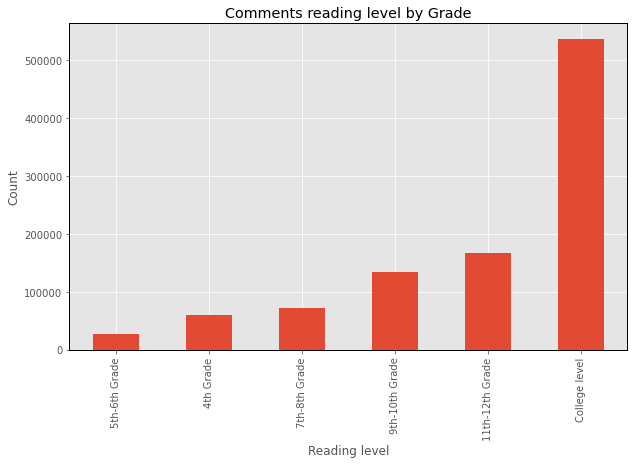

In [64]:
df.groupby('body_readability_qual').count().sort_values(by = 'date')['pos'].plot(kind = 'bar')
plt.xlabel('Reading level')
plt.ylabel('Count')
plt.title('Comments reading level by Grade')
plt.show()

In [65]:
# Average College level reader
df['body_readability_quant'].mean()

10.122208891531482

### Sentiment Analysis

In [66]:
df['neg neu pos'.split()].describe()

,neg,neu,pos
count,996364.000000,996364.000000,996364.000000
mean,0.095785,0.770216,0.133999
std,0.151628,0.211904,0.178840
min,0.000000,0.000000,0.000000
25%,0.000000,0.657000,0.000000
50%,0.000000,0.791000,0.079000
75%,0.148000,1.000000,0.205000
max,1.000000,1.000000,1.000000


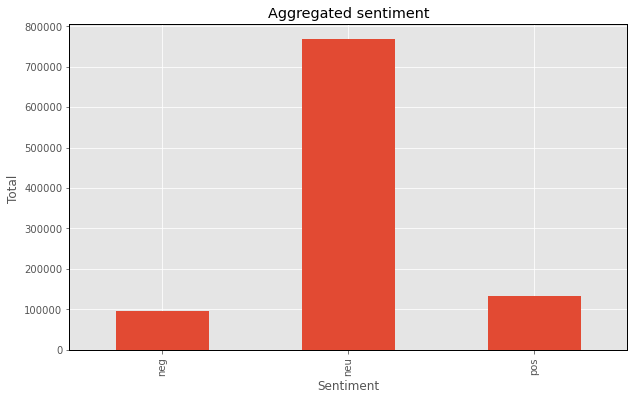

In [67]:
df['neg neu pos'.split()].sum().plot(kind = 'bar')
plt.xlabel('Sentiment')
plt.ylabel('Total ')
plt.title('Aggregated sentiment')
plt.show()

### Time series Analysis

In [155]:
def gen_timeseries_results(data, col, plot_phrase, y_lim_arr = None, t_test_side = 'less'):
    """
    Helper function to plot time series data
    And carry out hypothesis test. 
    
    """
    data = data.dropna()
    data[col].rolling(7).mean().plot()
    plt.xlabel('Time')
    plt.ylabel(f'Mean {plot_phrase}')
    plt.title(f'Mean {plot_phrase} Over Time, 7 day rolling average')
    plt.ylim(y_lim_arr)
    plt.show()
    
    _counts = data[col].to_numpy()
    _firsty = _counts[:365]
    _lasty = _counts[-365:]
    
    print(f'First year {plot_phrase} mean = {_firsty.mean()}')
    print(f'Last year {plot_phrase} mean = {_lasty.mean()}')
    
    print(stats.ttest_rel(_lasty, _firsty, alternative = t_test_side))

In [68]:
# Need to fix this.
df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'].dt.strftime('%d-%m-%Y'))

In [69]:
date_mean = df.groupby('date').mean().sort_values(by = 'date')
date_mean.head()

,score,body_word_count,body_character_count,body_num_errors,body_error_freq,body_readability_quant,body_readtime,body_sylcount,body_foreign_ease,neg,neu,pos,comp
date,,,,,,,,,,,,,
2018-04-10,7.000000,15.333333,68.333333,4.0,0.260000,9.490000,1.006667,1.333333,21.333333,0.000000,1.000000,0.000000,0.000000
2018-04-11,6.333333,8.000000,35.666667,1.0,0.214052,8.666667,0.526667,0.000000,6.666667,0.196667,0.658667,0.144667,-0.031267
2018-04-14,3.000000,88.000000,811.000000,18.0,0.204545,14.590000,11.910000,16.000000,15.100000,0.104000,0.896000,0.000000,-0.872300
2018-04-15,5.000000,14.000000,55.000000,1.0,0.071429,7.710000,0.810000,1.000000,21.000000,0.095000,0.683000,0.222000,0.499700
2018-04-16,7.000000,83.000000,413.000000,0.0,0.000000,9.980000,6.070000,9.000000,22.400000,0.026000,0.871000,0.103000,0.624900


#### Character count

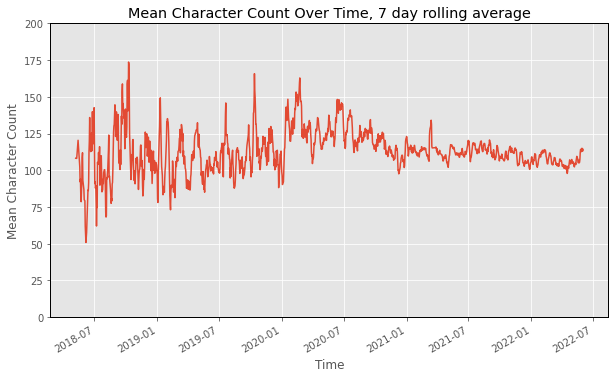

In [133]:
date_mean.loc[date_mean['body_character_count'] < 300]['body_character_count'].rolling(7).mean().plot()
plt.xlabel('Time')
plt.ylabel('Mean Character Count')
plt.title('Mean Character Count Over Time, 7 day rolling average')
plt.ylim([0,200])
plt.show()

In [80]:
# Carry out t test 
# Null hypoethesis = No difference.
char_counts = date_mean.loc[date_mean['body_character_count'] < 300]['body_character_count'].to_numpy()
charn_firsty = char_counts[:365]
charn_lasty = char_counts[-365:]

In [85]:
print(f'First year character count mean = {charn_firsty.mean()}')
print(f'Last year charcter count mean = {charn_lasty.mean()}')

First year character count mean = 106.90923000530954
Last year charcter count mean = 109.64496971776174


In [156]:
stats.ttest_rel(charn_lasty,charn_firsty, alternative = 'less')
# Failure to  reject Null Hypothesis

<IPython.core.display.Javascript object>

Ttest_relResult(statistic=1.1105026454452427, pvalue=0.8662422390664872)

#### Word count

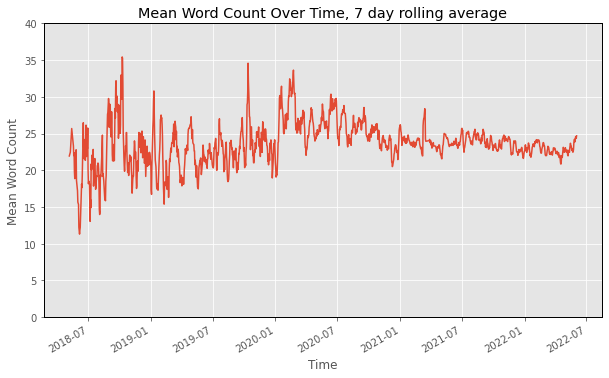

In [120]:
date_mean.loc[date_mean['body_word_count'] < 60]['body_word_count'].rolling(7).mean().plot()
plt.xlabel('Time')
plt.ylabel('Mean Word Count')
plt.title('Mean Word Count Over Time, 7 day rolling average')
plt.ylim([0,40])
plt.show()

In [121]:
# Carry out t test 
# Null hypoethesis = No difference.
word_counts = date_mean.loc[date_mean['body_word_count'] < 60]['body_word_count'].to_numpy()
word_firsty = word_counts[:365]
word_lasty = word_counts[-365:]

In [122]:
print(f'First year word count mean = {word_firsty.mean()}')
print(f'Last year word count mean = {word_lasty.mean()}')

First year word count mean = 21.96181699065917
Last year word count mean = 23.40619342714908


In [173]:
stats.ttest_rel(word_lasty, word_firsty, alternative = 'less')

<IPython.core.display.Javascript object>

Ttest_relResult(statistic=3.0071635183297856, pvalue=0.9985899030596217)

#### Error frequency

In [138]:
df.columns

Index(['date', 'score', 'body', 'body_word_count', 'body_character_count',
       'body_num_errors', 'body_error_freq', 'body_readability_qual',
       'body_readability_quant', 'body_readtime', 'body_sylcount',
       'body_foreign_ease', 'neg', 'neu', 'pos', 'comp'],
      dtype='object')

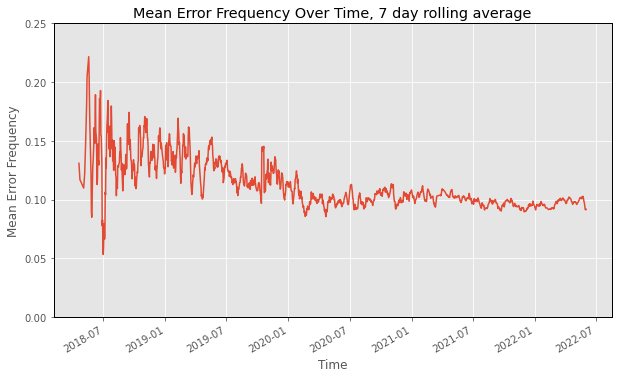

First year Error Frequency mean = 0.1370671622818839
Last year Error Frequency mean = 0.09763943248137633


<IPython.core.display.Javascript object>

Ttest_relResult(statistic=-13.754374951705971, pvalue=2.9454417812515034e-35)


In [161]:
gen_timeseries_results(date_mean, 'body_error_freq', 'Error Frequency', y_lim_arr = [0,0.25], t_test_side = 'less')

#### Reading Grade level

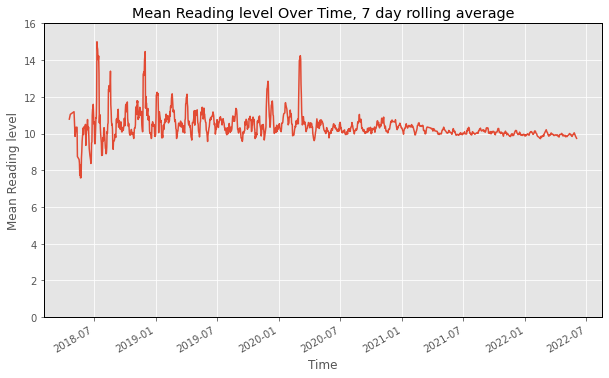

First year Reading level mean = 10.65396577650659
Last year Reading level mean = 10.021948305493426


<IPython.core.display.Javascript object>

Ttest_relResult(statistic=-4.783426540750054, pvalue=1.2539103386429639e-06)


In [274]:
gen_timeseries_results(date_mean, 'body_readability_quant', 'Reading level', y_lim_arr = [0,16], t_test_side = 'less')

### Word clouds

In [264]:
def generate_cloud(data):
    """
    Takes in a pandas series and generates a word cloud for it 
    carries out some filtering such as removing punctation and stopwords
    """
    data['text_proc'] = data['body'].map(lambda x: re.sub('[,\.!?]', '', x))
    data['text_proc'] = data['text_proc'].map(lambda x: x.lower())
    long_string = ','.join(data['text_proc'].values)
    
    # Word cloud instance
    wordcloud = WordCloud(background_color="black",
                          max_words=50,
                          contour_width=3, 
                          contour_color='steelblue',
                          stopwords = STOPWORDS)
    
    wordcloud.generate(long_string)
    plt.figure( figsize=(10,6) )
    plt.imshow(wordcloud)
    plt.grid(False)
    plt.show()

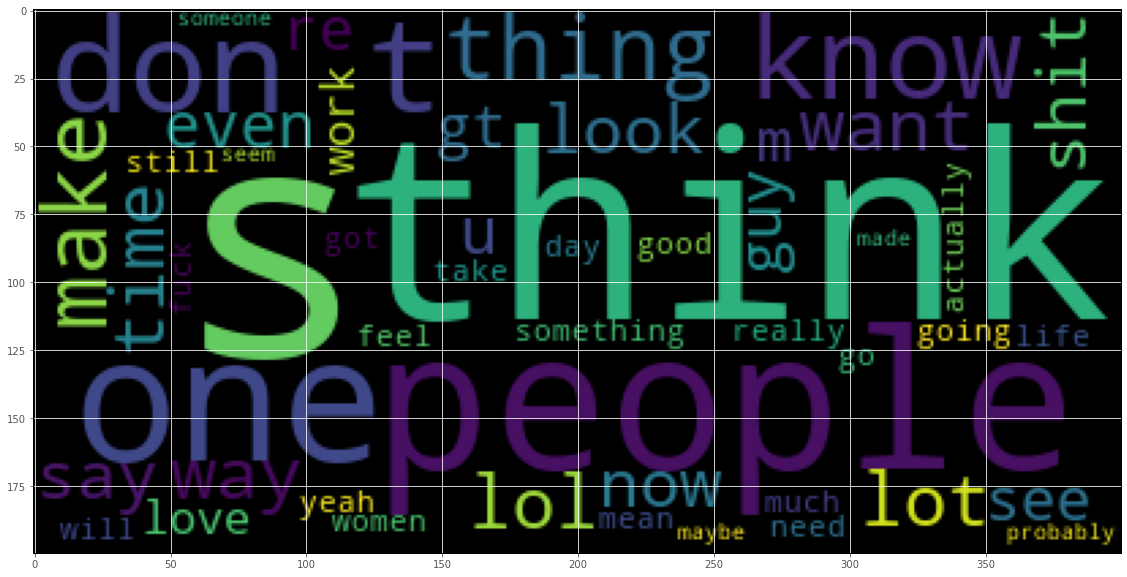

In [254]:
generate_cloud(df)

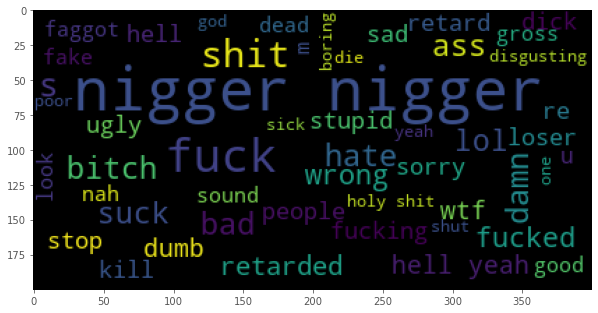

In [266]:
generate_cloud(df.loc[(df['neg'] > df['pos']) & (df['neg'] > df['neu'])])

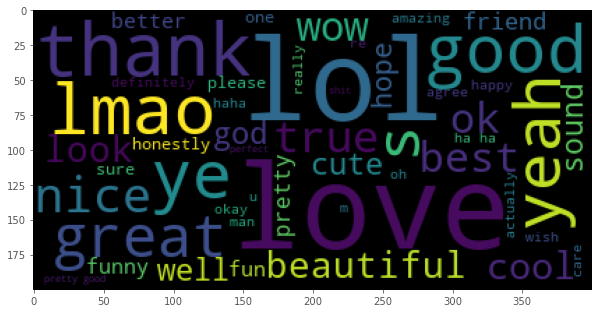

In [265]:
generate_cloud(df.loc[(df['pos'] > df['neg']) & (df['pos'] > df['neu'])])

In [267]:
df.columns

Index(['date', 'score', 'body', 'body_word_count', 'body_character_count',
       'body_num_errors', 'body_error_freq', 'body_readability_qual',
       'body_readability_quant', 'body_readtime', 'body_sylcount',
       'body_foreign_ease', 'neg', 'neu', 'pos', 'comp', 'text_proc'],
      dtype='object')